In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.1 MB/s eta 0:00:00


In [8]:
# Core utilities
import os
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from collections import Counter

# ML and evaluation
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Colab and display
from IPython.display import Image as IPImage, display
from google.colab import drive, files

# Testing
import glob
import shutil

In [9]:
print("Using GPU" if torch.cuda.is_available() else "Using CPU")

Using GPU


In [10]:
# Mount Google Drive
drive.mount('/content/drive')

# Define base project path
base_path = '/content/drive/MyDrive/PCB Defect Detection Project'

# Define subfolders
dataset_path = os.path.join(base_path, 'pcb.v1i.yolov8')
model_path = os.path.join(base_path, 'models')
results_path = os.path.join(base_path, 'results')

# Optional: Create folders if they don't exist
os.makedirs(model_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
#Helper Function to Draw YOLO Bounding Boxes
def draw_yolo_boxes(image_path, label_path, class_names, color=(0, 255, 0)):
    img = cv2.imread(image_path)
    h, w = img.shape[:2]

    with open(label_path, 'r') as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.strip().split())
            cls = int(cls)
            x1 = int((x - bw / 2) * w)
            y1 = int((y - bh / 2) * h)
            x2 = int((x + bw / 2) * w)
            y2 = int((y + bh / 2) * h)

            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, class_names[cls], (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return img


In [ ]:
# Load YOLOv8 small model — good balance of speed and accuracy
model = YOLO('yolov8s.pt')

# Train the model with best practices
model.train(
    data=os.path.join(dataset_path, 'data.yaml'),
    device= 0,
    epochs=100,
    imgsz=640,
    batch=16,
    patience=20,
    optimizer='Adam',
    lr0=0.001,
    warmup_epochs=3,
    save=True,
    save_period=10,
    val=True,
    augment=True,
    project=model_path,
    name='pcb_defect_model'
)


Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/PCB Defect Detection Project/pcb.v1i.yolov8/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pcb_defect_model6, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_ma

In [ ]:
# Load trained model
model = YOLO(os.path.join(model_path, 'pcb_defect_model', 'weights', 'best.pt'))

# Run prediction
model.predict(
    source=os.path.join(dataset_path, 'test', 'images'),
    save=True,
    save_txt=True,
    conf=0.25,
    project=results_path,
    name='predictions',
    verbose=False,
    show=False
)




image 1/509 /content/drive/MyDrive/PCB Defect Detection Project/pcb.v1i.yolov8/test/images/l_light_01_missing_hole_01_2_600_jpg.rf.13d14687449b82d7dcc2a0f7d1468a5e.jpg: 640x640 2 missing_holes, 16.0ms
image 2/509 /content/drive/MyDrive/PCB Defect Detection Project/pcb.v1i.yolov8/test/images/l_light_01_missing_hole_04_2_600_jpg.rf.c9212d5cda2b5c9a808065fdde897652.jpg: 640x640 2 missing_holes, 16.0ms
image 3/509 /content/drive/MyDrive/PCB Defect Detection Project/pcb.v1i.yolov8/test/images/l_light_01_missing_hole_11_2_600_jpg.rf.cb287e8f99c6079fc1244be2488c2a06.jpg: 640x640 1 missing_hole, 16.0ms
image 4/509 /content/drive/MyDrive/PCB Defect Detection Project/pcb.v1i.yolov8/test/images/l_light_01_missing_hole_11_5_600_jpg.rf.329fe0576a170f48c067bd2ffa3de41b.jpg: 640x640 1 missing_hole, 16.0ms
image 5/509 /content/drive/MyDrive/PCB Defect Detection Project/pcb.v1i.yolov8/test/images/l_light_01_missing_hole_13_3_600_jpg.rf.f9c7ffc8523c34df88d6459c927516e8.jpg: 640x640 2 missing_holes, 16.

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'missing_hole', 1: 'mouse_bite', 2: 'open_circuit', 3: 'short', 4: 'spur', 5: 'spurious_copper'}
 obb: None
 orig_img: array([[[ 52, 148,  24],
         [ 49, 145,  21],
         [ 43, 140,  19],
         ...,
         [ 34, 136,   1],
         [ 32, 136,   0],
         [ 31, 135,   0]],
 
        [[ 59, 155,  31],
         [ 51, 147,  23],
         [ 42, 137,  16],
         ...,
         [ 32, 133,   1],
         [ 34, 137,   2],
         [ 38, 141,   6]],
 
        [[ 66, 160,  35],
         [ 53, 150,  24],
         [ 41, 137,  13],
         ...,
         [ 31, 131,   2],
         [ 36, 138,   7],
         [ 43, 145,  14]],
 
        ...,
 
        [[  9,  91,   8],
         [ 13,  95,  12],
         [ 15,  98,  13],
         ...,
         [  8, 107,   3],
         [  6, 105,   3],
         [  7, 106,   4]],
 
        [[ 12,  94,  11

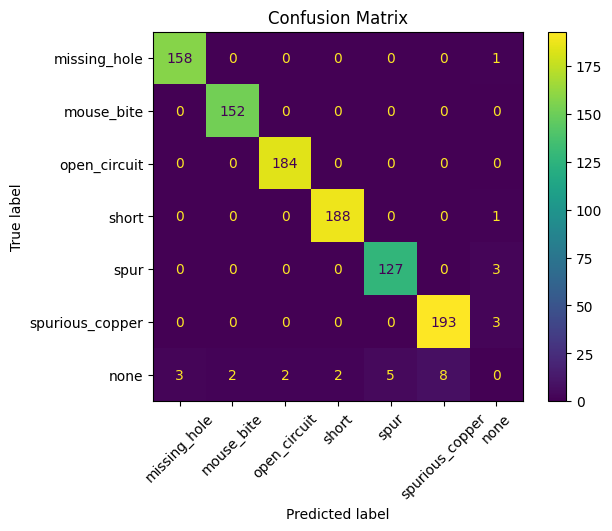

In [ ]:
gt_dir = os.path.join(dataset_path, 'test', 'labels')
pred_dir = os.path.join(results_path, 'predictions', 'labels')
class_names = ['missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur', 'spurious_copper']

y_true, y_pred = [], []

for filename in os.listdir(gt_dir):
    if filename.endswith('.txt'):
        gt_path = os.path.join(gt_dir, filename)
        pred_path = os.path.join(pred_dir, filename)

        gt_classes = [int(line.split()[0]) for line in open(gt_path)]
        pred_classes = [int(line.split()[0]) for line in open(pred_path)] if os.path.exists(pred_path) else []

        for gt_class in gt_classes:
            y_true.append(class_names[gt_class])
            y_pred.append(class_names[pred_classes.pop(0)] if pred_classes else 'none')

        for pred_class in pred_classes:
            y_true.append('none')
            y_pred.append(class_names[pred_class])

labels = class_names + ['none']
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Load trained model once
model = YOLO(os.path.join(model_path, 'pcb_defect_model', 'weights', 'best.pt'))

# Upload one or more images from PC
uploaded = files.upload()

# Use a fixed folder for saving all predictions
save_subfolder = 'test_predictions'
save_dir = os.path.join(results_path, save_subfolder)

# Delete the folder if it exists to prevent YOLO from auto-incrementing
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)

# Run predictions and display results for each image
for filename in uploaded.keys():
    # Run prediction
    model.predict(
        source=filename,
        save=True,
        conf=0.25,
        project=results_path,
        name=save_subfolder
    )

    # YOLO renames files with spaces/parentheses → find the saved image dynamically
    base_name = os.path.splitext(os.path.basename(filename))[0]
    base_name_clean = base_name.replace(' ', '_').replace('(', '').replace(')', '')
    matches = glob.glob(os.path.join(save_dir, f"{base_name_clean}*.jpg"))

    if matches:
        display(IPImage(filename=matches[0]))
    else:
        print(f"⚠️ Could not find saved image for {filename}. Check if YOLO renamed it differently.")


Saving thumb (1).jpg to thumb (1).jpg

image 1/1 /content/thumb (1).jpg: 640x544 8 spurious_coppers, 44.6ms
Speed: 2.8ms preprocess, 44.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)
Results saved to /content/drive/MyDrive/PCB Defect Detection Project/results/test_predictions
⚠️ Could not find saved image for thumb (1).jpg. Check if YOLO renamed it differently.


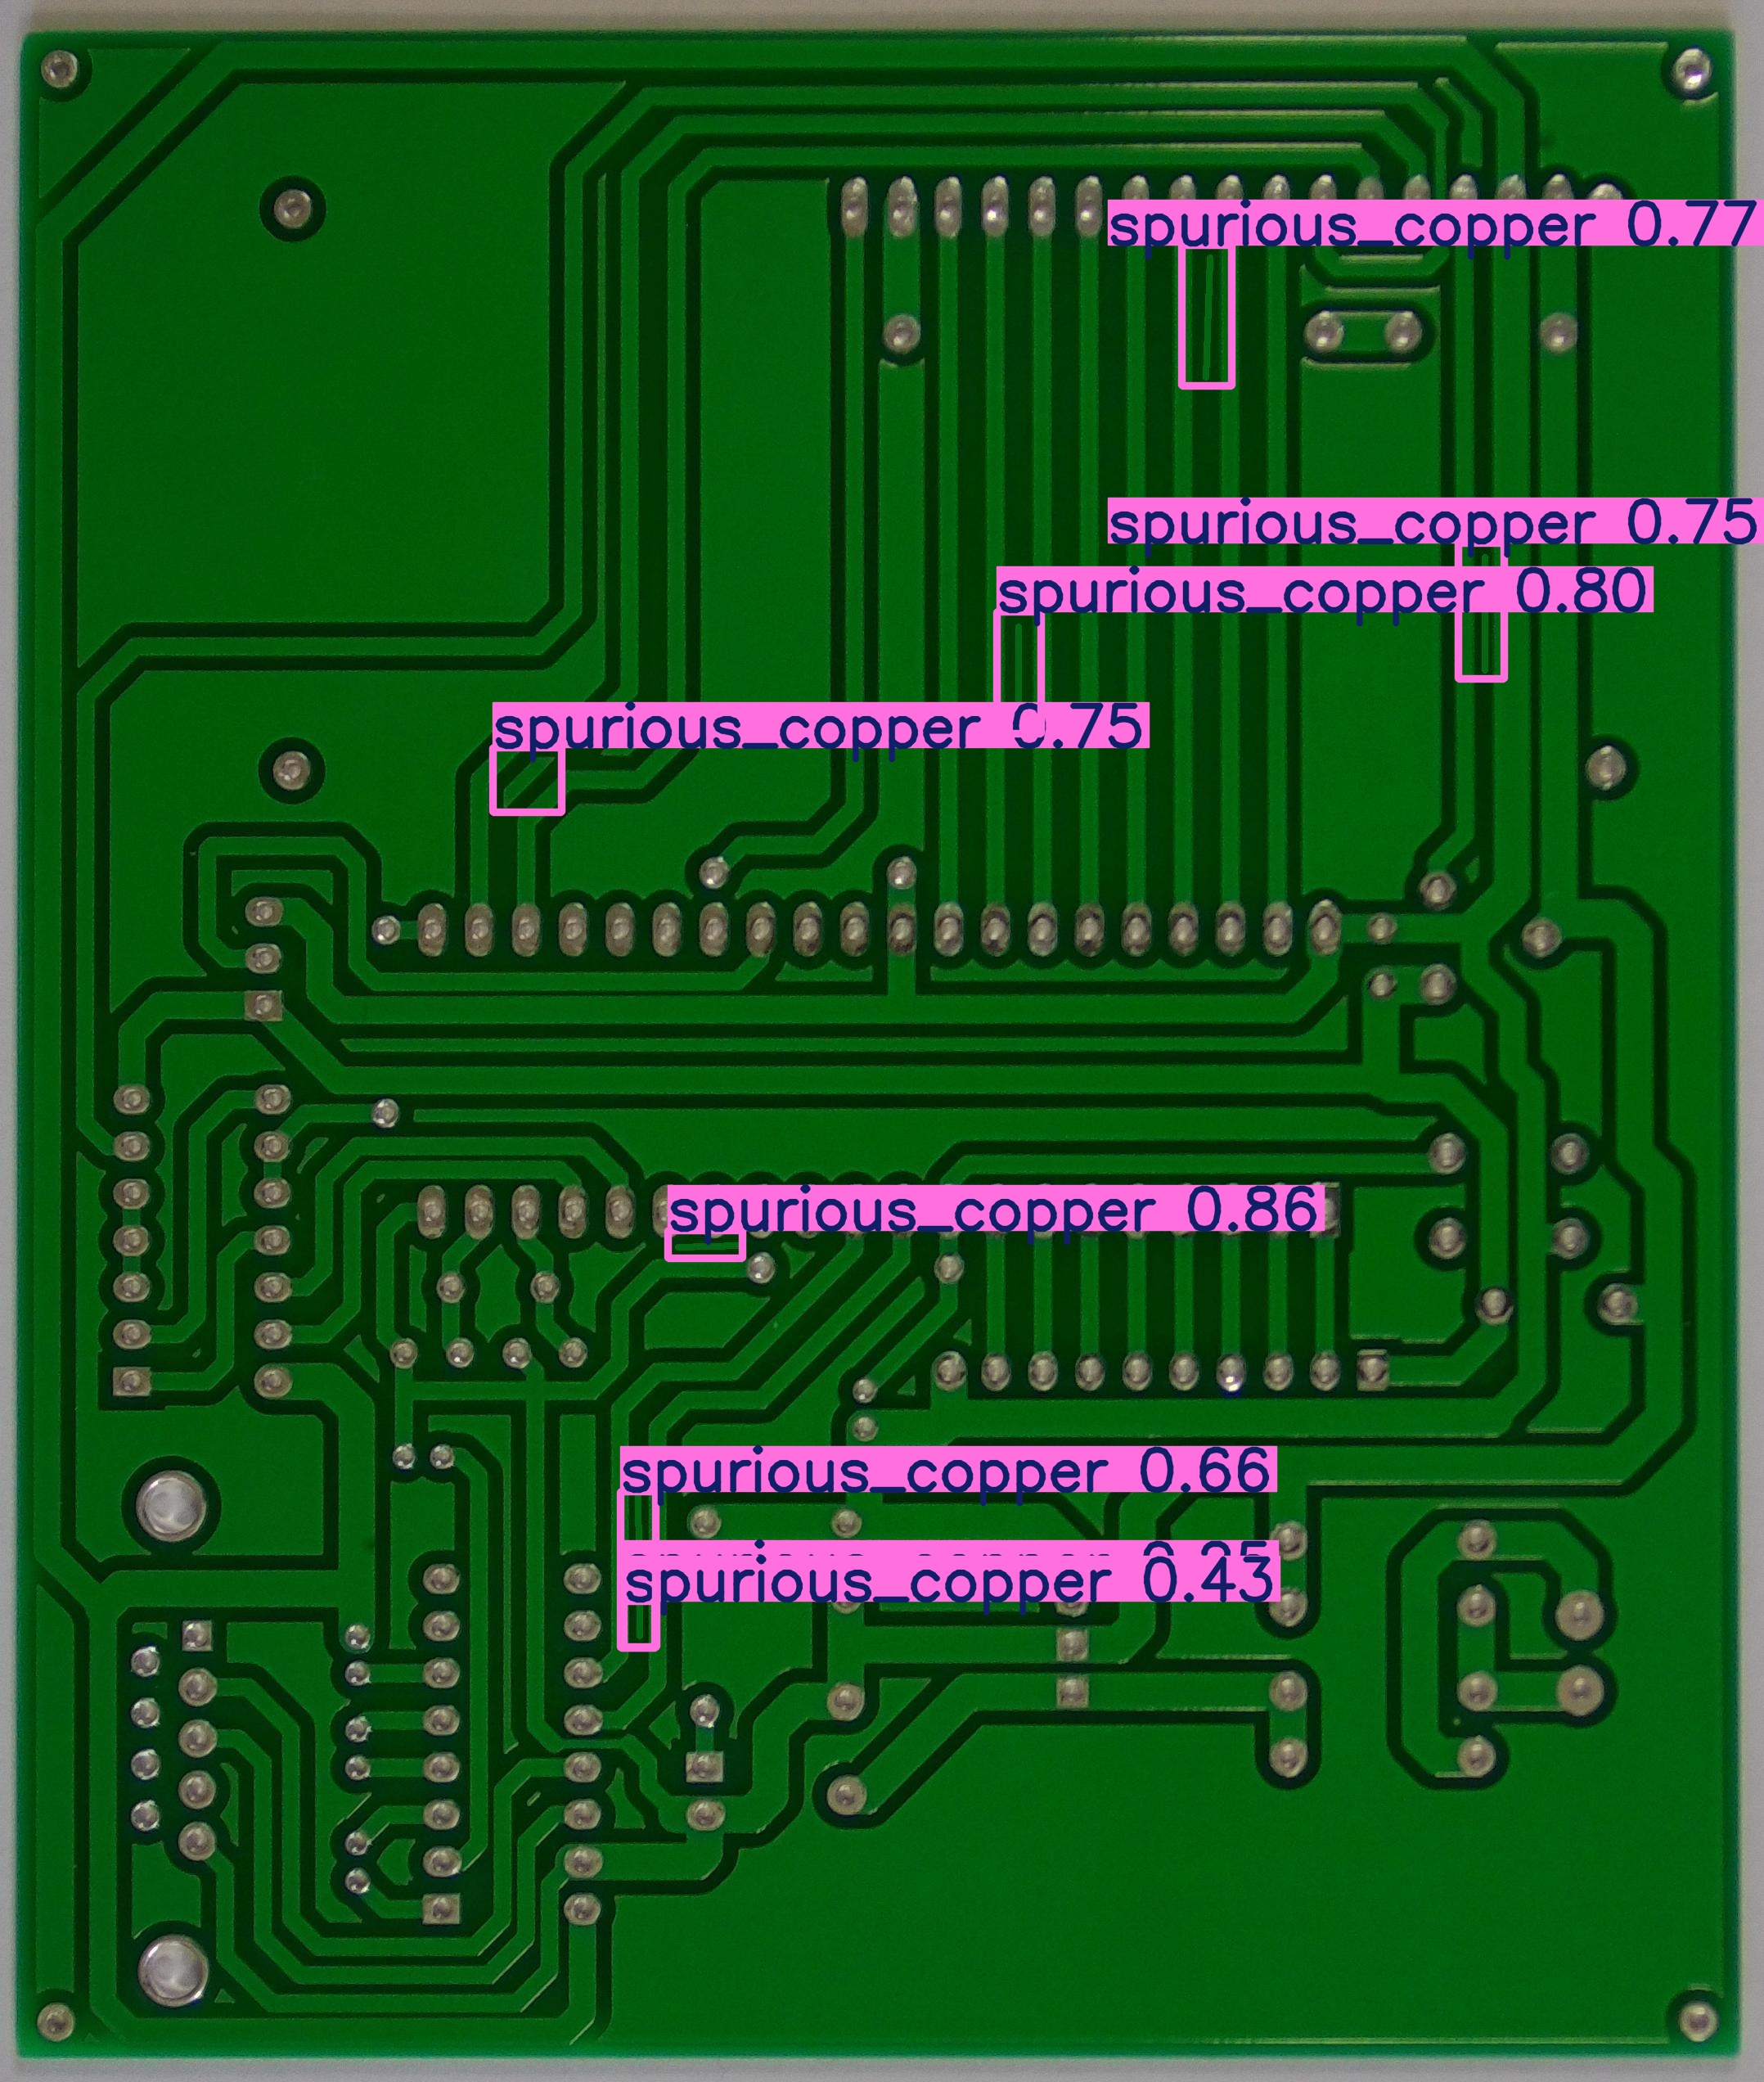

In [ ]:

# Find the most recently saved image in the prediction folder
latest_images = sorted(glob.glob(os.path.join(save_dir, '*.jpg')), key=os.path.getmtime, reverse=True)

# Display the most recent one
if latest_images:
    display(IPImage(filename=latest_images[0]))
else:
    print("⚠️ No annotated image found. Check if YOLO saved it correctly.")